In [1]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0,"../")
from global_config import config

results_dir           = config.get_property('results_dir')
data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")

COLOR_LIST1           = ["#F8AFA8", "#FDDDA0", "#F5CDB4", "#74A089"]

In [2]:
patient_df               = pd.read_csv(os.path.join(data_db_dir, "long_files_8_25_2021", "patient_movement_2022-Nov.csv"), parse_dates=['date'])
patient_df               = patient_df.drop_duplicates(['date','mrn'])
patient_df["ward_total"] = patient_df.apply(lambda x: x["ward"]+"-"+x["building"]+"-"+x["place"], axis=1)

ward2id                  = {w: i for i, w in enumerate(patient_df["ward_total"].index.values)}

#duplicated_pos_tests = (patient_df[['mrn','organism_name']].duplicated() & ~patient_df['organism_name'].isnull())
duplicated_pos_tests = (patient_df[['encounter_id','organism_name']].duplicated() & ~patient_df['organism_name'].isnull())

patient_df.loc[duplicated_pos_tests,'test']          = 0
patient_df.loc[duplicated_pos_tests,'organism_name'] = np.nan

#patient_df["ward_id"] = patient_df["ward_total"].apply(lambda x: ward2id[x])

wards                 = patient_df.ward_total.unique()

date_min            = pd.to_datetime("2020-02-01")
date_max            = pd.to_datetime("2021-02-28")

dates_simulation = pd.date_range(start=date_min, end=date_max, freq="D")

amro_search = ['ESCHERICHIA COLI', 'KLEBSIELLA PNEUMONIAE', 'PSEUDOMONAS AERUGINOSA', 'METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS',
                'METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS', 'STAPHYLOCOCCUS EPIDERMIDIS', 'ENTEROCOCCUS FAECALIS', 'ENTEROCOCCUS FAECIUM']




In [3]:
amro_df = pd.DataFrame()

for amro in amro_search:
    print("creating {} observations".format(amro))
    amro_counts_df         = pd.DataFrame(columns=wards, index=dates_simulation); amro_counts_df.index.name = "date"
    amro_counts_df         = pd.DataFrame(amro_counts_df.unstack()).reset_index().rename(columns={"level_0":"ward", 0: "value"})
    amro_counts_df["amro"] = amro
    amro_counts_df         = amro_counts_df.set_index(["date", "ward"])
    amro_counts_df         = amro_counts_df.fillna(0)

    for date in tqdm.tqdm(dates_simulation):
        today     = pd.to_datetime(date)
        today_df  = patient_df[patient_df["date"]==today]

        today_df         = today_df[today_df.test==1].copy()
        today_df         = today_df[today_df.organism_name.isin(amro_search)]
        today_df["keep"] = today_df["organism_name"].apply(lambda x: amro in str(x))
        today_df         = today_df[today_df["keep"]==True]
        amro_counts_df.loc[(date, today_df["ward_total"].values), "value"] += len(today_df)

    amro_df = pd.concat([amro_df, amro_counts_df])

amro_df

creating ESCHERICHIA COLI observations


100%|██████████| 394/394 [00:04<00:00, 88.63it/s]


creating KLEBSIELLA PNEUMONIAE observations


100%|██████████| 394/394 [00:04<00:00, 83.14it/s]


creating PSEUDOMONAS AERUGINOSA observations


100%|██████████| 394/394 [00:04<00:00, 83.27it/s] 


creating METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS observations


100%|██████████| 394/394 [00:04<00:00, 81.87it/s]


creating METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS observations


100%|██████████| 394/394 [00:04<00:00, 93.19it/s] 


creating STAPHYLOCOCCUS EPIDERMIDIS observations


100%|██████████| 394/394 [00:03<00:00, 100.98it/s]


creating ENTEROCOCCUS FAECALIS observations


100%|██████████| 394/394 [00:04<00:00, 95.83it/s] 


creating ENTEROCOCCUS FAECIUM observations


100%|██████████| 394/394 [00:03<00:00, 107.04it/s]


,,value,amro
date,ward,,
2020-02-01,Pby Adult Emergency-Presbyterian Hospital-Columbia,1,ESCHERICHIA COLI
2020-02-02,Pby Adult Emergency-Presbyterian Hospital-Columbia,0,ESCHERICHIA COLI
2020-02-03,Pby Adult Emergency-Presbyterian Hospital-Columbia,0,ESCHERICHIA COLI
2020-02-04,Pby Adult Emergency-Presbyterian Hospital-Columbia,0,ESCHERICHIA COLI
2020-02-05,Pby Adult Emergency-Presbyterian Hospital-Columbia,6,ESCHERICHIA COLI
...,...,...,...
2021-02-24,Mil 4 Micu A-Mschony-Chony,0,ENTEROCOCCUS FAECIUM
2021-02-25,Mil 4 Micu A-Mschony-Chony,0,ENTEROCOCCUS FAECIUM
2021-02-26,Mil 4 Micu A-Mschony-Chony,0,ENTEROCOCCUS FAECIUM


In [5]:
data_df

,date,value
0,2020-02-02,7
1,2020-02-09,134
2,2020-02-16,129
3,2020-02-23,190
4,2020-03-01,245
5,2020-03-08,156
6,2020-03-15,255
7,2020-03-22,188
8,2020-03-29,124
9,2020-04-05,210


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_12502/3409364456.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_df = amro_df.reset_index().groupby(["date", "amro"]).sum().unstack([1]).resample("W-Sun").sum().stack().reset_index()
/Users/chaosdonkey06/anaconda3/envs/pompjax/lib/python3.8/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/chaosdonkey06/anaconda3/envs/pompjax/lib/python3.8/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/chaosdonkey06/anaconda3/envs/pompjax/lib/python3.8/s

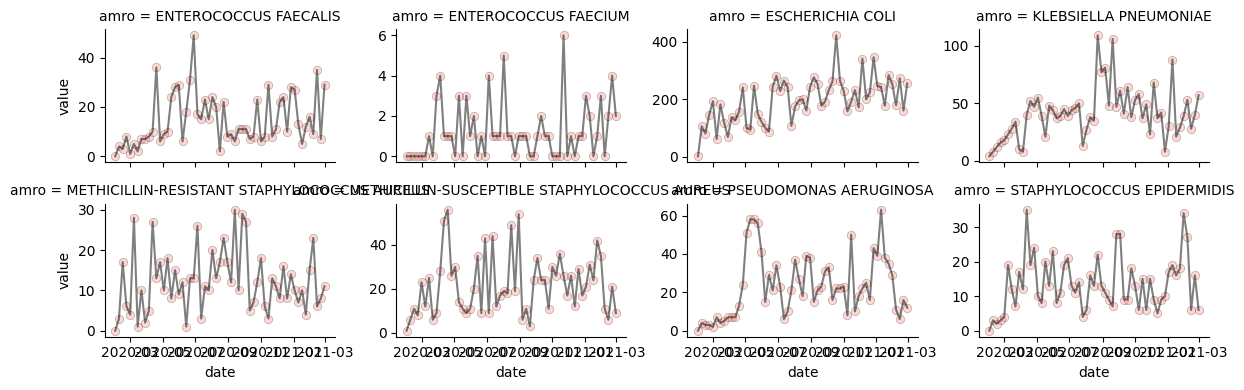

In [18]:
data_df = amro_df.reset_index().groupby(["date", "amro"]).sum().unstack([1]).resample("W-Sun").sum().stack().reset_index()

import seaborn as sns
g = sns.FacetGrid(data_df, col="amro", col_wrap=4, height=2, aspect=1.5, sharey=False)
g.map(sns.scatterplot, "date", "value", edgecolor="k", facecolor="salmon", alpha=0.3)
g.map(sns.lineplot, "date", "value", color="black", alpha=0.5)


In [ ]:
amro_df.to_csv(     os.path.join(data_db_dir, "long_files_8_25_2021", "amro_ward.csv" ),   index=False)
